In [61]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from math import log10
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from astropy.table import Table
from astropy.cosmology import Planck13
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
%matplotlib inline

# Read data

In [3]:
cat="/Users/marchuertascompany/data/SDSS/Nair/Nair_Abraham.fit"
data=fits.getdata(cat,1)
t=Table(data)
print(t)
print(t.colnames)

        JID             RA    DEC     z   zconf ... dist tails   RC3      Tt   
-------------------- ------- ------ ----- ----- ... ---- ----- ------- --------
J155341.74-003422.84 238.424 -0.573 0.078   1.0 ...  0.0   0.0 999999  999999.0
J155146.83-000618.62 237.946 -0.105 0.055   1.0 ...  0.0   0.0 999999  999999.0
J154453.22+002415.48 236.222  0.405 0.034   1.0 ...  0.0   0.0 999999  999999.0
J154711.32+002424.81 236.798  0.407 0.033 0.962 ...  0.0   0.0 999999  999999.0
J154514.39+004619.89  236.31  0.773 0.013   1.0 ...  0.0   0.0 .SAS7?. 999999.0
J155255.43+004304.87 238.231  0.719 0.033 0.999 ...  0.0   0.0 999999  999999.0
J155357.40+004117.11  238.49  0.689 0.039 0.998 ...  0.0   0.0 999999  999999.0
J110122.00-010824.89 165.342  -1.14 0.074 0.999 ...  0.0   0.0 999999       0.0
J112000.06-010711.96 170.001 -1.119 0.025  0.99 ...  0.0   0.0 999999  999999.0
J112408.63-010927.83 171.036 -1.157  0.03 0.998 ...  0.0   0.0 .LXR0..      2.0
                 ...     ...    ...   ..

# Define feautures and labels

In [59]:


#define feature to use
nf=2
f1=data['g-r'] #color
f2=data['n_r'] #Sersic index

#define two classes (early/late)
ttype=data["TType"]
m=ttype*0-1
m[np.where((ttype>0) & ((ttype<=10)))]=1
m[np.where((ttype<=0) & ((ttype>=-5)))]=0


#remove bad values
p=np.where((f1>-1) & (f1<2) & (f2>0) & (f2<6) & (m>=0))


#target vector
label_vector=m[p]

#feature vector
feature_vector=np.zeros((label_vector.shape[0],2))
feature_vector[:,0]=f1[p]
feature_vector[:,1]=f2[p]


#divide test/train datasets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, label_vector, test_size=0.33, random_state=42)
print("Sizes training / test")
print(X_train.shape)
print(X_test.shape)

Sizes training / test
(9070, 2)
(4468, 2)


# Plot featues histograms

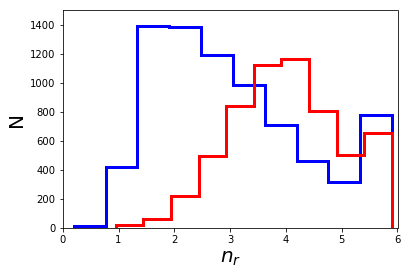

(array([  2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.30000000e+01,   4.50000000e+01,   1.57000000e+02,
          6.09000000e+02,   3.92000000e+03,   1.12800000e+03,
          1.00000000e+01]),
 array([ 0.053 ,  0.1452,  0.2374,  0.3296,  0.4218,  0.514 ,  0.6062,
         0.6984,  0.7906,  0.8828,  0.975 ]),
 <a list of 1 Patch objects>)

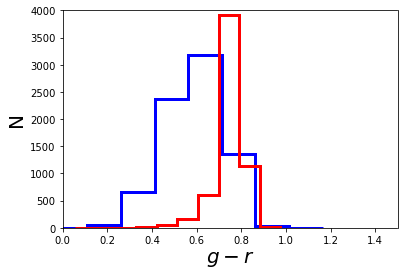

In [50]:
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1500)
plt.hist(feature_vector[label_vector==1,1],histtype='step',color='blue',linewidth=3)
plt.hist(feature_vector[label_vector==0,1],histtype='step',color='red',linewidth=3)
plt.show()
plt.xlabel("$g-r$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.xlim(0,1.5)
plt.ylim(0,4000)
plt.hist(feature_vector[label_vector==1,0],histtype='step',color='blue',linewidth=3)
plt.hist(feature_vector[label_vector==0,0],histtype='step',color='red',linewidth=3)

# Plot feature space

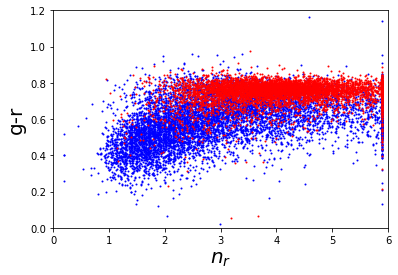

In [55]:
plt.xlabel("$n_r$", fontsize=20)
plt.ylabel("g-r", fontsize=20)
plt.xlim(0,6)
plt.ylim(0,1.2)
plt.scatter(feature_vector[label_vector==1,1],feature_vector[label_vector==1,0],color='blue',s=1)
plt.scatter(feature_vector[label_vector==0,1],feature_vector[label_vector==0,0],color='red',s=1)

# Train

In [70]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print("Trained RF Classifier")
print(clf)
print("Importance of each feature")
print(clf.feature_importances_)

Trained RF Classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Importance of each feature
[ 0.50589684  0.49410316]


# Test

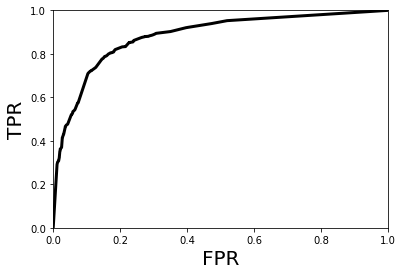

In [71]:
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

#plot ROC
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr,linewidth=3,color='black')

# Visualize tree [optional]

In [75]:
i_tree = 0
for tree_in_forest in clf.estimators_:
    with open("/Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.dot", "w") as f:
        f = export_graphviz(tree_in_forest, out_file=f)
    i_tree = i_tree + 1    
os.system('dot -Tpng /Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.dot -o /Users/marchuertascompany/Documents/teaching/big_data_ED/RF_ML.png')

0